# Dietary Compass: Personalized Food Choice Navigator

## PART 1: Standalone Web Scraping Scripts

### Scraper 1: FDA Nutrition Facts Scraper

1. Scrape all the useful paragraphs and store in as dataframe

In [5]:
import requests
import lxml.html as lx
import re
import json
import pandas as pd

# Define the FDA URL
FDA_URL = "https://www.fda.gov/food/nutrition-facts-label/how-understand-and-use-nutrition-facts-label"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.84 Safari/537.36"
}

def get_paragraphs_after_heading(html, heading):
    paragraphs = []

    # Get the xpath of the heading
    heading_path = html.getroottree().getpath(heading)

    # Find all elements after this heading
    for element in html.xpath(f"{heading_path}/following::*"):
        # Stop if we hit another heading
        if element.tag in ['h1', 'h2', 'h3', 'h4']:
            break

        if element.tag == 'p':
            # Process paragraph text
            para_text = ""

            # Get initial text
            if element.text:
                para_text += element.text

            # Process child elements
            for child in element:
                if child.tag in ['strong', 'b']:
                    para_text += f"**{child.text_content()}**"
                elif child.tag == 'a':
                    para_text += f"[{child.text_content()}]({child.get('href', '')})"
                if child.tail:
                    para_text += child.tail

            # Clean up
            para_text = re.sub(r'\*?\(#\d+ on sample label\)\*?', '', para_text).strip()

            if para_text:
                paragraphs.append(para_text)

    return paragraphs

def scrape_fda_nutrition_facts():
    # Fetch the webpage
    response = requests.get(FDA_URL, headers=HEADERS)

    if response.status_code != 200:
        print(f"Failed to retrieve the webpage. Status code: {response.status_code}")
        return None

    # Parse the HTML
    html = lx.fromstring(response.content)

    # Define sections to extract
    sections = [
        {"id": "ServingInformation", "title": "1. Serving Information"},
        {"id": "Calories", "title": "2. Calories"},
        {"id": "Nutrients", "title": "3. Nutrients"},
        {"id": "PercentDailyValue", "title": "4. The Percent Daily Value (%DV)"}
    ]

    # Extract content for each section
    results = {}
    for section in sections:
        # Find the anchor for this section
        anchor = html.xpath(f'//a[@id="{section["id"]}" or @name="{section["id"]}"]')

        if not anchor:
            print(f"Section with ID '{section['id']}' not found.")
            results[section["title"]] = {"title": section["title"], "paragraphs": [f"Section with ID '{section['id']}' not found."]}
            continue

        # Find the parent heading
        heading = None
        current = anchor[0]
        while current is not None:
            if current.tag in ['h1', 'h2', 'h3', 'h4']:
                heading = current
                break
            current = current.getparent()

        if heading is None:
            print(f"Heading for section '{section['id']}' not found.")
            results[section["title"]] = {"title": section["title"], "paragraphs": [f"Heading for section '{section['id']}' not found."]}
            continue

        # Get title
        title = heading.text_content().strip()

        # Get paragraphs
        paragraphs = get_paragraphs_after_heading(html, heading)

        results[section["title"]] = {
            'title': title,
            'paragraphs': paragraphs
        }

    return results

def create_nutrition_facts_dataframe(nutrition_facts):
    # Prepare data for DataFrame
    df_data = []

    for section_title, content in nutrition_facts.items():
        if isinstance(content, str):
            # Handle error case
            df_data.append({
                'Section': section_title,
                'Content': content,
            })
        else:
            # Process normal content
            for paragraph in content.get('paragraphs', []):
                # Skip rows that only contain formatting marks
                if paragraph.strip() in ["**", "**Example**"] or paragraph.strip() == "":
                    continue

                df_data.append({
                    'Section': section_title,
                    'Content': paragraph,
                })

    # Create DataFrame
    df = pd.DataFrame(df_data)
    return df

def main():
    # Main execution
    nutrition_facts = scrape_fda_nutrition_facts()

    if nutrition_facts:
        # Save to JSON
        with open("fda_nutrition_facts.json", "w") as f:
            json.dump(nutrition_facts, f, indent=2)

        # Create DataFrame
        nutrition_df = create_nutrition_facts_dataframe(nutrition_facts)

        # Save DataFrame to CSV
        nutrition_df.to_csv("nutrition_facts.csv", index=False)

        # Display DataFrame
        print("Nutrition Facts Information:")
        print(nutrition_df)

        return nutrition_df
    else:
        print("Failed to scrape nutrition facts information.")
        return None

if __name__ == "__main__":
    main()

Nutrition Facts Information:
                             Section  \
0             1. Serving Information   
1             1. Serving Information   
2                        2. Calories   
3                        2. Calories   
4                        2. Calories   
5                       3. Nutrients   
6                       3. Nutrients   
7                       3. Nutrients   
8                       3. Nutrients   
9                       3. Nutrients   
10                      3. Nutrients   
11                      3. Nutrients   
12                      3. Nutrients   
13                      3. Nutrients   
14                      3. Nutrients   
15  4. The Percent Daily Value (%DV)   
16  4. The Percent Daily Value (%DV)   
17  4. The Percent Daily Value (%DV)   
18  4. The Percent Daily Value (%DV)   
19  4. The Percent Daily Value (%DV)   
20  4. The Percent Daily Value (%DV)   
21  4. The Percent Daily Value (%DV)   
22  4. The Percent Daily Value (%DV)   
23  4. The 

2. Pick information and reorganize the dataframe to get ready of implementing in our application

In [7]:
# Read the nutrition_facts.csv file into a DataFrame
nutrition_df = pd.read_csv('nutrition_facts.csv')

# Rename the 'Section' column to 'Head' and add a new 'Section' column
nutrition_df = nutrition_df.rename(columns={'Section': 'Head'})
nutrition_df['Section'] = None

# Define a function to assign sections
def assign_sections(df):
    # Section 1: Rows 0-1
    df.loc[0:1, 'Section'] = 'Section1'
    # Section 2: Rows 2-4
    df.loc[2:4, 'Section'] = 'Section2'
    # Section 3: Row 6
    df.loc[6, 'Section'] = 'Section3'
    df.loc[6, 'Content'] = 'Nutrients to get less of: Saturated Fat, Sodium, and Added Sugars. ' + df.loc[6, 'Content']
    # Section 4: Rows 7-10
    df.loc[7:10, 'Section'] = 'Section4'
    # Section 5: Row 13
    df.loc[13, 'Section'] = 'Section5'
    df.loc[13, 'Content'] = 'Nutrients to get more of: Dietary Fiber, Vitamin D, Calcium, Iron, and Potassium. ' + df.loc[13, 'Content']
    # Section 6: Rows 15-19
    df.loc[15:19, 'Section'] = 'Section6'
    # Section 7: Rows 23-25
    df.loc[23:25, 'Section'] = 'Section7'
    # Section 8: Rows 35-38
    df.loc[35:38, 'Section'] = 'Section8'

# Call the function to assign sections
assign_sections(nutrition_df)

# Filter out rows that have not been assigned to a section
nutrition_df = nutrition_df[nutrition_df['Section'].notnull()]

# Keep all other columns intact
nutrition_df = nutrition_df[['Section', 'Head'] + [col for col in nutrition_df.columns if col not in ['Section', 'Head']]]

# Print the result
print(nutrition_df)

     Section                              Head  \
0   Section1            1. Serving Information   
1   Section1            1. Serving Information   
2   Section2                       2. Calories   
3   Section2                       2. Calories   
4   Section2                       2. Calories   
6   Section3                      3. Nutrients   
7   Section4                      3. Nutrients   
8   Section4                      3. Nutrients   
9   Section4                      3. Nutrients   
10  Section4                      3. Nutrients   
13  Section5                      3. Nutrients   
15  Section6  4. The Percent Daily Value (%DV)   
16  Section6  4. The Percent Daily Value (%DV)   
17  Section6  4. The Percent Daily Value (%DV)   
18  Section6  4. The Percent Daily Value (%DV)   
19  Section6  4. The Percent Daily Value (%DV)   
23  Section7  4. The Percent Daily Value (%DV)   
24  Section7  4. The Percent Daily Value (%DV)   
25  Section7  4. The Percent Daily Value (%DV)   


### Scraper 2: Wikipedia RDI Scraper

In [9]:
import pandas as pd
import requests
import re

# URL for the Wikipedia page containing nutritional data
WIKI_URL = "https://en.wikipedia.org/wiki/Reference_Daily_Intake"

# Headers to avoid being blocked
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

def clean_text(string):
    return re.sub(r'\s*\[.*?\]|,|\n', '', string).strip() if isinstance(string, str) else string

def extract_value_and_unit(value):
    if isinstance(value, str):
        match = re.search(r'(\d+\.?\d*)\s*([a-zA-Z]+)', value)
        return (float(match.group(1)), match.group(2)) if match else (float(re.findall(r'\d+\.?\d*', value)[0]), "") if re.findall(r'\d+\.?\d*', value) else (None, "")
    return None, ""

# Make the request to Wikipedia
response = requests.get(WIKI_URL, headers=HEADERS)

if response.status_code == 200:
    # Use pandas to extract tables from the page
    tables = pd.read_html(WIKI_URL)

    # Find the table with nutritional data
    for table in tables:
        if any("Nutrient" in str(col) for col in table.columns):

            # Clean the table data
            table.columns = [clean_text(col) for col in table.columns]
            table = table.map(clean_text)

            # Create new dataframe to store processed data
            processed_table = pd.DataFrame({'Nutrient': table['Nutrient']})

            # Extract values and units
            for col in table.columns[1:]:
                values_and_units = table[col].apply(extract_value_and_unit)
                processed_table[f"{col}_Value"] = [x[0] for x in values_and_units]
                processed_table[f"{col}_Unit"] = [x[1] for x in values_and_units]

            # Display the entire table with units
            print("Processed Data:")
            pd.set_option('display.max_rows', None)
            pd.set_option('display.max_columns', None)
            pd.set_option('display.width', 1000)
            print(processed_table)
            break
    else:
        print("No suitable table found on the page.")
else:
    print(f"Failed to fetch data from Wikipedia. Status code: {response.status_code}")

Processed Data:
                Nutrient  DV_Value DV_Unit
0              Total fat      78.0       g
1  Saturated fatty acids      20.0       g
2            Cholesterol     300.0      mg
3                 Sodium    2300.0      mg
4              Potassium    4700.0      mg
5     Total carbohydrate     275.0       g
6           Added sugars      50.0       g
7          Dietary fiber      28.0       g
8                Protein      50.0       g


## PART 2: Integrated Main Application Code

1. Preparation

In [12]:
import requests
import pandas as pd
import time
import json
import re
import matplotlib.pyplot as plt
from typing import Dict, Optional, List
import random
import io
import base64
from IPython.display import display, HTML
import sys

# Constants
SEARCH_URL = "https://world.openfoodfacts.org/cgi/search.pl"
PRODUCT_URL = "https://world.openfoodfacts.org/api/v0/product/{}.json"

# Sleep time between API requests to avoid overwhelming the server
SLEEP_TIME = 0.5

# Map API nutrient with Wiki data
NUTRIENT_MAPPING = {
    "energy-kcal_100g": "Calories",
    "fat_100g": "Total fat",
    "saturated-fat_100g": "Saturated fatty acids",
    "cholesterol_100g": "Cholesterol",
    "sodium_100g": "Sodium",
    "carbohydrates_100g": "Total carbohydrate",
    "sugars_100g": "Added sugars",
    "fiber_100g": "Dietary fiber",
    "proteins_100g": "Protein"
}

# Dietary options mapping to API tags
DIETARY_OPTIONS = {
    "vegan": "en:vegan",
    "vegetarian": "en:vegetarian",
    "gluten-free": "en:gluten-free",
    "lactose-free": "en:lactose-free"
}

# Global cache to store API responses and avoid redundant calls
cache = {}

2. API Interation

In [14]:
# Function to request data with rate limiting
def make_request(url, params=None):
    try:
        # Create a cache key from the URL and parameters
        cache_key = f"{url}_{str(params)}"

        # Return cached result if available
        if cache_key in cache:
            return cache[cache_key]

        # Make the request
        response = requests.get(url, params=params, headers=HEADERS)
        time.sleep(SLEEP_TIME)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse JSON response
            data = response.json()
            cache[cache_key] = data
            return data
        else:
            print(f"Error: Request failed with status code {response.status_code}")
            return None
    except Exception as e:
        print(f"Error making request: {e}")
        return None

# Function to search for products by name
def fetch_products_by_name(product_name, fields=None):
    params = {
        "search_terms": product_name,
        "search_simple": 1,
        "action": "process",
        "json": 1,
    }

    if fields:
        params["fields"] = fields

    data = make_request(SEARCH_URL, params)

    if data and "products" in data:
        return data["products"]
    return []

# Function to get product details by barcode
def fetch_product_details(barcode):
    data = make_request(PRODUCT_URL.format(barcode))

    if data and data.get("status") == 1:
        return data["product"]
    return None

3. User Interaction

In [16]:
# Function to get product from user (by name or barcode)
def get_product_from_user():
    print("\nSearch Options:")
    print("1. Search by Product Name")
    print("2. Search by Barcode")
    print("3. Go Back to Main Menu")

    choice = input("Select (1-3): ").strip()

    if choice == "1":
        # Search by product name
        product_name = input("\nEnter a food name (e.g., 'chocolate', 'milk', 'pasta'): ")
        print(f"\nSearching for {product_name}...")
        products = fetch_products_by_name(product_name)

        if not products:
            print("No products found. Try a different name.")
            return None

        # Filter out empty product names
        valid_products = [p for p in products if p.get("product_name") and p.get("product_name").strip()]

        if not valid_products:
            print("No valid products found with proper names. Try a different search term.")
            return None

        # Display search results for user to choose from
        print("\nAvailable products:")
        for i, product in enumerate(valid_products[:10], 1):
            barcode = product.get('code', 'No barcode')
            print(f"{i}. {product.get('product_name', 'Unknown')} (Barcode: {barcode})")

        print(f"{len(valid_products[:10])+1}. Go Back to Search Options")

        try:
            selected_index = int(input("\nSelect a product by number: ")) - 1
            if 0 <= selected_index < len(valid_products):
                # Retrieve product details
                return fetch_product_details(valid_products[selected_index]["code"])
            elif selected_index == len(valid_products):
                # Go back to search options
                return get_product_from_user()
            else:
                print("Invalid selection.")
                return None
        except ValueError:
            print("Invalid input. Please enter a number.")
            return None

    elif choice == "2":
        # Search by barcode
        barcode = input("\nEnter product barcode: ").strip()
        print(f"\nSearching for barcode {barcode}...")
        product = fetch_product_details(barcode)

        if not product:
            print("Product not found. Try a different barcode.")

        return product

    elif choice == "3":
        # Go back to main menu
        return "main_menu"

    else:
        print("Invalid choice.")
        return None

4. Data Processing & Cleaning

In [18]:
# Function to clean text (remove footnotes, special characters, etc.)
def clean_text(string):
    if isinstance(string, str):
        return re.sub(r'\s*\[.*?\]|,|\n', '', string).strip()
    return string

# Function to extract numeric values from strings
def extract_numeric(value):
    if isinstance(value, str):
        num_match = re.findall(r'\d+\.?\d*', value)
        if num_match:
            return float(num_match[0])
    return None

5.1 Food Health Analysis - Allergen Check

In [20]:
# Function to check product allergens
def check_allergens(product):
    allergens = product.get("allergens_tags", [])
    allergen_list = [a.replace("en:", "").capitalize() for a in allergens]
    if not allergen_list:
        return "No allergens listed"
    return ", ".join(allergen_list)

5.2 Food Health Analysis - Processing Score

In [22]:
# Function to calculate processing score
def calculate_processing_score(product):
    # Use get() with default value to handle missing nova_group
    nova_score = int(product.get("nova_group", 4))
    additives_count = len(product.get("additives_tags", []))

    # Calculate a simple processing score (higher is less processed)
    processing_score = 100 - (nova_score * 15 + min(additives_count * 5, 40))
    return max(0, processing_score)

# Function to get NOVA explanation
def get_nova_explanation(nova_score):
    explanations = {
        1: "Unprocessed or minimally processed foods",
        2: "Processed culinary ingredients",
        3: "Processed foods",
        4: "Ultra-processed foods"
    }
    return explanations.get(nova_score, "Unknown processing level")

5.3 Food Health Analysis - Find Healthier Alternatives

In [24]:
# Function to analyze healthier alternatives
def analyze_healthier_alternatives(product):
    # Exit early if no product data is available
    if not product:
        print("\nNo product data available to find alternatives.")
        return

    product_name = product.get("product_name", "Unknown")
    print(f"\nFinding healthier alternatives for {product_name}...")

    # Collect search strategies
    search_terms = []

    # Strategy 1: Extract main product category
    categories = product.get("categories_tags", [])
    main_category = categories[0].replace("en:", "") if categories else None

    # Strategy 2: Extract specific product type from categories
    product_type = None
    relevant_types = ["spread", "cream", "sauce", "butter", "oil", "drink",
                      "snack", "chocolate", "yogurt", "cheese", "milk"]

    for category in categories:
        category_clean = category.replace("en:", "").lower()
        if any(type_word in category_clean for type_word in relevant_types):
            product_type = category_clean
            break

    # Strategy 3: Extract product type from product name
    if not product_type and len(product_name.split()) > 1:
        name_words = product_name.lower().split()
        for word in name_words:
            if any(type_word == word for type_word in relevant_types):
                product_type = word
                break

    # Strategy 4: Use product brands to find items from competitors
    brands = product.get("brands_tags", [])
    main_brand = brands[0].replace("en:", "") if brands else None

    # Build list of search terms in order of relevance
    if product_type:
        search_terms.append(product_type)

    # Use more specific categories if available
    if categories and len(categories) > 1:
        second_category = categories[1].replace("en:", "")
        if second_category and "food" not in second_category.lower():
            search_terms.append(second_category)

    # Add main category if it's specific enough
    if main_category and not any(generic in main_category.lower()
                             for generic in ["food", "beverage", "product"]):
        search_terms.append(main_category)

    # Use brand competitors as fallback
    if main_brand:
        search_terms.append(main_brand)

    # Finally use the first word of product name as fallback
    if not search_terms:
        search_terms.append(product_name.split()[0])

    # Remove duplicates while preserving order
    search_terms = list(dict.fromkeys(search_terms))

    # Log search strategy to help user understand results
    print(f"Search strategy: Using terms {', '.join(search_terms)}")

    # Search for each term and collect all results
    all_products = []
    for term in search_terms:
        products = fetch_products_by_name(term)
        if products:
            for p in products:
                if p not in all_products:  # Avoid duplicates
                    all_products.append(p)

    if not all_products:
        print("\nNo similar products found.")
        return

    print(f"Found {len(all_products)} products to analyze.")

    # Process and score products to find alternatives
    processed_products = []

    # Get nutritional values of original product for comparison
    original_nutrients = product.get("nutriments", {})
    original_calories = original_nutrients.get("energy-kcal_100g", 0)
    original_sugar = original_nutrients.get("sugars_100g", 0)
    original_fat = original_nutrients.get("fat_100g", 0)
    original_salt = original_nutrients.get("salt_100g", 0)
    original_nutriscore = product.get("nutriscore_grade", "Unknown")

    for p in all_products:
        # Skip products without name
        if not p.get("product_name"):
            continue

        # Skip the current product
        if p.get("product_name") == product_name:
            continue

        p_nutrients = p.get("nutriments", {})

        # Ensure we have the basic nutritional values
        if ("energy-kcal_100g" not in p_nutrients or
            "sugars_100g" not in p_nutrients or
            "fat_100g" not in p_nutrients):
            continue

        # Calculate similarity and health scores
        p_nutriscore = p.get("nutriscore_grade", "Unknown")

        # Check category match for relevance
        category_match = False
        p_categories = p.get("categories_tags", [])

        if categories and p_categories:
            common_categories = set(categories) & set(p_categories)
            category_match = len(common_categories) > 0

        # Calculate nutrient improvements over original
        calories_better = original_calories > 0 and p_nutrients.get("energy-kcal_100g", 0) < original_calories
        sugar_better = original_sugar > 0 and p_nutrients.get("sugars_100g", 0) < original_sugar
        fat_better = original_fat > 0 and p_nutrients.get("fat_100g", 0) < original_fat
        salt_better = original_salt > 0 and p_nutrients.get("salt_100g", 0) < original_salt

        # Convert nutriscore to numeric (a=0, e=4)
        def score_to_numeric(score):
            if score and score.lower() in 'abcde':
                return ord(score.lower()) - ord('a')
            return 4  # Default to worst score

        original_score_num = score_to_numeric(original_nutriscore)
        p_score_num = score_to_numeric(p_nutriscore)
        nutriscore_better = p_score_num < original_score_num

        # Calculate overall health improvement score (higher is better)
        health_improvement = 0
        health_improvement += 3 if calories_better else 0
        health_improvement += 2 if sugar_better else 0
        health_improvement += 2 if fat_better else 0
        health_improvement += 1 if salt_better else 0
        health_improvement += 3 if nutriscore_better else 0

        # Calculate relevance score (higher is more relevant)
        relevance_score = 0
        relevance_score += 5 if category_match else 0
        relevance_score += 2 if any(term.lower() in p.get("product_name", "").lower() for term in search_terms) else 0

        # Store the product with its scores
        processed_products.append({
            "name": p.get("product_name", "Unknown"),
            "nutri_score": p_nutriscore,
            "calories": p_nutrients.get("energy-kcal_100g", 0),
            "sugar": p_nutrients.get("sugars_100g", 0),
            "fat": p_nutrients.get("fat_100g", 0),
            "salt": p_nutrients.get("salt_100g", 0),
            "health_improvement": health_improvement,
            "relevance": relevance_score,
            "category_match": category_match
        })

    # Filter out invalid products
    valid_products = [p for p in processed_products
                     if p["calories"] > 0 and p["sugar"] >= 0 and p["fat"] >= 0]

    if not valid_products:
        print("\nNo comparable products with complete nutrition info found.")
        return

    # Sort by combined score (relevance + health improvement)
    # For products with high relevance, we prioritize health improvements
    ranked_products = sorted(
        valid_products,
        key=lambda p: (-(p["relevance"] + p["health_improvement"]), -p["relevance"])
    )

    # Display top 5 healthier alternatives
    print("\nTop 5 Most Relevant Healthy Alternatives:\n")
    for i, product in enumerate(ranked_products[:5], 1):
        health_indicators = []
        if product["calories"] < original_calories:
            health_indicators.append("Lower calories")
        if product["sugar"] < original_sugar:
            health_indicators.append("Lower sugar")
        if product["fat"] < original_fat:
            health_indicators.append("Lower fat")

        health_benefits = ", ".join(health_indicators) if health_indicators else "Similar nutritional profile"

        print(f"{i}. {product['name']}")
        print(f"   Nutri-Score: {product['nutri_score'].upper() if product['nutri_score'] != 'Unknown' else 'Not available'}")
        print(f"   Calories: {product['calories']:.1f} kcal per 100g")
        print(f"   Sugar: {product['sugar']:.1f}g per 100g")
        print(f"   Fat: {product['fat']:.1f}g per 100g")
        print(f"   Benefits: {health_benefits}")
        print(f"   {'✓ Similar category' if product['category_match'] else 'Different category'}\n")

    return

5.4 Food Health Analysis - Nutritional Analysis

In [26]:
# Function to fix %DV calculation and visualization to account for portion sizes
def calculate_dv_with_portion_size(product, dv_data):

    food_nutrients = product.get("nutriments", {})
    portion_size = product.get("serving_size", 100)

    # Improved serving size extraction logic
    if isinstance(portion_size, str):
        # First try to extract gram value in parentheses
        parentheses_match = re.search(r'\((\d+\.?\d*)\s*g\)', portion_size)
        if parentheses_match:
            portion_size = float(parentheses_match.group(1))
        else:
            # If no gram value in parentheses, try to extract any number
            match = re.search(r'\d+\.?\d*', portion_size)
            if match:
                portion_size = float(match.group())
            else:
                portion_size = 100

    print(f"Serving Size: {portion_size}g")

    nutrients_found = []
    dv_values = []
    nutrient_amounts = []
    nutrient_units = []

    for openfood_key, wiki_name in NUTRIENT_MAPPING.items():
        if openfood_key in food_nutrients:
            food_value = food_nutrients.get(openfood_key, 0)

            # Adjust for portion size
            adjusted_value = (food_value * portion_size) / 100

            # Find the matching row in the DV data
            dv_row = dv_data[dv_data["Nutrient"].str.lower() == wiki_name.lower()]

            if not dv_row.empty and dv_row.iloc[0, 1] not in [0, None]:
                dv = dv_row.iloc[0, 1]  # Get the daily value
                dv_unit = dv_row.iloc[0, 2] if len(dv_row.iloc[0]) > 2 else "g"
                dv_percentage = (adjusted_value / dv) * 100 if dv else 0

                # Store for visualization
                nutrients_found.append(wiki_name)
                dv_values.append(dv_percentage)
                nutrient_amounts.append(adjusted_value)
                nutrient_units.append(dv_unit)

                # Print the information
                print(f"{wiki_name}: {adjusted_value:.2f}{dv_unit} ({dv_percentage:.2f}% DV)")

    # Create visualization
    if nutrients_found:
        try:
            # Create the plot
            plt.figure(figsize=(10, 6))

            # Color coding based on DV percentages
            colors = ['green' if val < 20 else 'orange' if val < 50 else 'red' for val in dv_values]

            # Create horizontal bar chart
            bars = plt.barh(nutrients_found, dv_values, color=colors)

            # Add percentage labels to the end of each bar
            for i, bar in enumerate(bars):
                width = bar.get_width()
                plt.text(width + 1, bar.get_y() + bar.get_height()/2,
                         f"{dv_values[i]:.1f}% ({nutrient_amounts[i]:.1f}{nutrient_units[i]})",
                         va='center')

            # Add reference lines
            plt.axvline(x=20, color='orange', linestyle='--', alpha=0.7)
            plt.axvline(x=50, color='red', linestyle='--', alpha=0.7)

            # Add labels and title
            plt.xlabel('% Daily Value')
            plt.title('Nutritional Content as % of Daily Value')
            plt.tight_layout()

            # Display the chart inline in notebook
            plt.show(block=False)
            plt.close()

        except Exception as e:
            print(f"Error creating visualization: {e}")
            print("Falling back to text-based representation...")

            # Create simple text bars as fallback
            print("\n\nNutritional Content as % of Daily Value:")
            print("=" * 50)
            for i, nutrient in enumerate(nutrients_found):
                percent = dv_values[i]
                level = "LOW" if percent < 20 else "MEDIUM" if percent < 50 else "HIGH"
                print(f"{nutrient}: {percent:.1f}% ({level})")
            print("=" * 50)
    else:
        print("\nNot enough nutrition data available for visualization.")

    return nutrients_found, dv_values, nutrient_amounts

6. Nutritional Education & Information Display

In [28]:
# Function to integrate nutrition tag educational content
def integrate_fda_education():
    # Create a loop to stay in the nutrition label information menu
    while True:
        # Display available sections to the user
        print("\nNutrition Facts Label Information Sections:")
        print("1. Serving Information")
        print("2. Calories")
        print("3. Nutrients")
        print("4. The Percent Daily Value (%DV)")
        print("5. Return to Main Menu")

        # Get user selection
        choice = input("\nSelect a section to learn more (1-5): ").strip()

        if choice == "1":
            head = "1. Serving Information"
        elif choice == "2":
            head = "2. Calories"
        elif choice == "3":
            head = "3. Nutrients"
        elif choice == "4":
            head = "4. The Percent Daily Value (%DV)"
        elif choice == "5":
            # Return to main menu
            return
        else:
            print("Invalid choice. Please try again.")
            continue

        # Get relevant rows from the nutrition_df for the selected head
        section_content = nutrition_df[nutrition_df['Head'] == head]

        if section_content.empty:
            print("No information available for this section.")
            continue

        # Display the section header
        print(f"\n{head}")
        print("-" * 50)

        # Display the content for each row in the section
        for _, row in section_content.iterrows():
            content = row['Content']
            if isinstance(content, str):
                # Check if it's a subsection
                if content.startswith('**'):
                    # Extract subsection title
                    sub_title_end = content.find('**', 2)
                    if sub_title_end != -1:
                        sub_title = content[2:sub_title_end]
                        sub_content = content[sub_title_end+2:].strip()
                        print(f"\n{sub_title}")
                        print("-" * 40)
                        # Format the subcontent with proper line breaks
                        words = sub_content.split()
                        formatted_text = ""
                        line = ""
                        for word in words:
                            if len(line) + len(word) + 1 <= 100:
                                if line:
                                    line += " " + word
                                else:
                                    line = word
                            else:
                                formatted_text += line + "\n"
                                line = word
                        if line:
                            formatted_text += line
                        print(formatted_text)
                    else:
                        print(content)
                else:
                    # Format the content with proper line breaks
                    words = content.split()
                    formatted_text = ""
                    line = ""
                    for word in words:
                        if len(line) + len(word) + 1 <= 100:
                            if line:
                                line += " " + word
                            else:
                                line = word
                        else:
                            formatted_text += line + "\n"
                            line = word
                    if line:
                        formatted_text += line
                    print(formatted_text)
                    print()

# Function to analyze food products
def analyze_food_product():
    product = get_product_from_user()

    if product == "main_menu":
        return

    if not product:
        print("No product data available.")
        return

    # Loop to stay within the product analysis menu
    while True:
        print("\nProduct Analysis Options:")
        print("1. Allergen Check")
        print("2. Processing Score")
        print("3. Find Healthier Alternatives")
        print("4. Nutritional Analysis")
        print("5. Go Back to Main Menu")

        choice = input("\nSelect analysis type (1-5): ")

        if choice == "1":
            # Allergen check
            allergens = check_allergens(product)
            print(f"\nAllergen Information: {allergens}")

        elif choice == "2":
            # Processing score
            score = calculate_processing_score(product)
            nova = product.get("nova_group", 4)
            nova_explanation = get_nova_explanation(nova)

            print(f"\nProcessing Score: {score:.1f}/100")
            print(f"NOVA Group: {nova} - {nova_explanation}")

            # Display additives
            additives = product.get("additives_tags", [])
            if additives:
                print("\nAdditives:")
                for additive in additives:
                    print(f"- {additive.replace('en:', '')}")
            else:
                print("\nNo additives listed.")

        elif choice == "3":
            # Find healthier alternatives
            analyze_healthier_alternatives(product)

        elif choice == "4":
            # Nutritional analysis
            print("\nNutritional Analysis:")
            # Use the global processed_table table
            global processed_table
            calculate_dv_with_portion_size(product, processed_table)

        elif choice == "5":
            # Return to main menu
            return

        else:
            print("\nInvalid choice.")

7. Main Function

### Demo 1--Search by name


DIETARY COMPASS: PERSONALIZED FOOD CHOICE NAVIGATOR

Please select a tool:
1. Food Product Analyzer - Analyze food products in different ways
2. Know more about nutrition tag - Learn how to interpret food labels
3. Exit
--------------------------------------------------



Enter your choice (1-3):  1



Search Options:
1. Search by Product Name
2. Search by Barcode
3. Go Back to Main Menu


Select (1-3):  1

Enter a food name (e.g., 'chocolate', 'milk', 'pasta'):  nutella



Searching for nutella...

Available products:
1. Nutella (Barcode: 3017620425035)
2. Nutella (Barcode: 3017620422003)
3. Biscuits croquants au coeur onctueux de Nutella® (Barcode: 8000500310427)
4. Nutella (Barcode: 3017620429484)
5. nutella (Barcode: 59032823)
6. Лешниково-какаов крем (Barcode: 80176800)
7. Nutella (Barcode: 4008400401621)
8. Nutella (Barcode: 8000500179864)
9. Nutella (Barcode: 4008400404127)
10. Pâte à tartiner Nutella noisettes et cacao - 750g (Barcode: 3017620421006)
11. Go Back to Search Options



Select a product by number:  2



Product Analysis Options:
1. Allergen Check
2. Processing Score
3. Find Healthier Alternatives
4. Nutritional Analysis
5. Go Back to Main Menu



Select analysis type (1-5):  1



Allergen Information: Milk, Nuts, Soybeans

Product Analysis Options:
1. Allergen Check
2. Processing Score
3. Find Healthier Alternatives
4. Nutritional Analysis
5. Go Back to Main Menu



Select analysis type (1-5):  2



Processing Score: 30.0/100
NOVA Group: 4 - Ultra-processed foods

Additives:
- e322
- e322i

Product Analysis Options:
1. Allergen Check
2. Processing Score
3. Find Healthier Alternatives
4. Nutritional Analysis
5. Go Back to Main Menu



Select analysis type (1-5):  3



Finding healthier alternatives for Nutella...
Search strategy: Using terms spreads, breakfasts, nutella
Found 124 products to analyze.

Top 5 Most Relevant Healthy Alternatives:

1. Nutella & Go 52 g
   Nutri-Score: D
   Calories: 264.0 kcal per 100g
   Sugar: 22.7g per 100g
   Fat: 13.1g per 100g
   Benefits: Lower calories, Lower sugar, Lower fat
   ✓ Similar category

2. cruesly mélange de noix
   Nutri-Score: B
   Calories: 462.0 kcal per 100g
   Sugar: 12.0g per 100g
   Fat: 19.0g per 100g
   Benefits: Lower calories, Lower sugar, Lower fat
   ✓ Similar category

3. Quaker Rolled Oats
   Nutri-Score: A
   Calories: 374.0 kcal per 100g
   Sugar: 1.1g per 100g
   Fat: 8.0g per 100g
   Benefits: Lower calories, Lower sugar, Lower fat
   ✓ Similar category

4. Muesli Superfruits
   Nutri-Score: A
   Calories: 357.0 kcal per 100g
   Sugar: 14.0g per 100g
   Fat: 6.0g per 100g
   Benefits: Lower calories, Lower sugar, Lower fat
   ✓ Similar category

5. Simply nutty muesli
   Nutri-Sco


Select analysis type (1-5):  4



Nutritional Analysis:
Serving Size: 15.0g
Total fat: 4.63g (5.94% DV)
Saturated fatty acids: 1.59g (7.95% DV)
Sodium: 0.01mg (0.00% DV)
Total carbohydrate: 8.62g (3.14% DV)
Added sugars: 8.45g (16.89% DV)
Protein: 0.94g (1.89% DV)


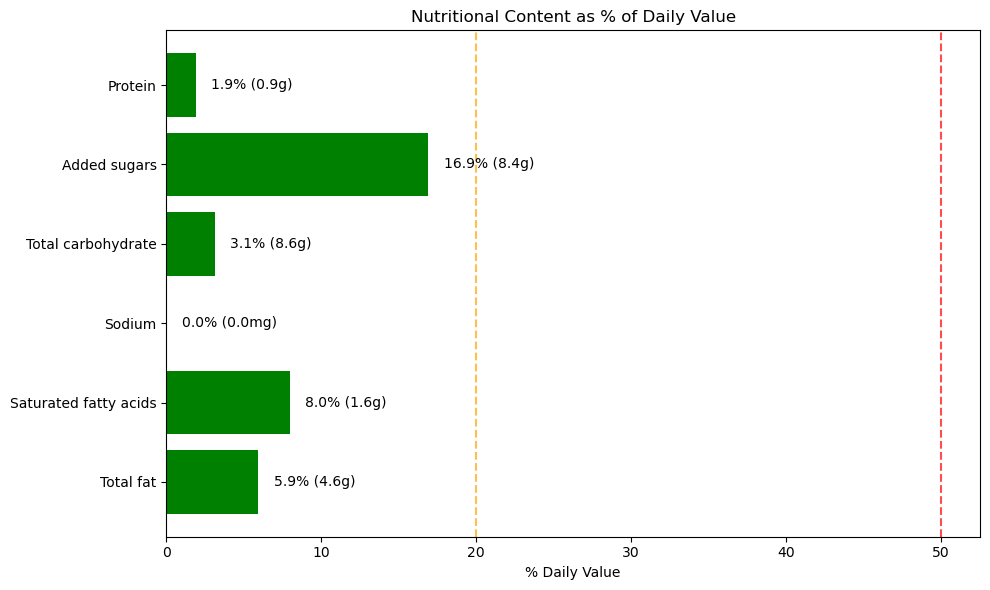


Product Analysis Options:
1. Allergen Check
2. Processing Score
3. Find Healthier Alternatives
4. Nutritional Analysis
5. Go Back to Main Menu



Select analysis type (1-5):  5



DIETARY COMPASS: PERSONALIZED FOOD CHOICE NAVIGATOR

Please select a tool:
1. Food Product Analyzer - Analyze food products in different ways
2. Know more about nutrition tag - Learn how to interpret food labels
3. Exit
--------------------------------------------------



Enter your choice (1-3):  3



Thank you for using Dietary Compass! Goodbye!


In [30]:
# Function to ensure proper menu navigation
def ensure_menu_navigation():
    while True:
        print("\n" + "="*50)
        print("DIETARY COMPASS: PERSONALIZED FOOD CHOICE NAVIGATOR")
        print("="*50)
        print("\nPlease select a tool:")
        print("1. Food Product Analyzer - Analyze food products in different ways")
        print("2. Know more about nutrition tag - Learn how to interpret food labels")
        print("3. Exit")
        print("-"*50)

        choice = input("\nEnter your choice (1-3): ")

        if choice == "1":
            analyze_food_product()

        elif choice == "2":
            integrate_fda_education()

        elif choice == "3":
            print("\nThank you for using Dietary Compass! Goodbye!")
            break

        else:
            print("\nInvalid choice. Please enter a number between 1 and 3.")

# Main function to run the Dietary Compass application
def main():
    ensure_menu_navigation()
if __name__ == "__main__":
    main()

### Demo 2--Search by barcode


DIETARY COMPASS: PERSONALIZED FOOD CHOICE NAVIGATOR

Please select a tool:
1. Food Product Analyzer - Analyze food products in different ways
2. Know more about nutrition tag - Learn how to interpret food labels
3. Exit
--------------------------------------------------



Enter your choice (1-3):  1



Search Options:
1. Search by Product Name
2. Search by Barcode
3. Go Back to Main Menu


Select (1-3):  2

Enter product barcode:  767707001203



Searching for barcode 767707001203...

Product Analysis Options:
1. Allergen Check
2. Processing Score
3. Find Healthier Alternatives
4. Nutritional Analysis
5. Go Back to Main Menu



Select analysis type (1-5):  1



Allergen Information: Milk

Product Analysis Options:
1. Allergen Check
2. Processing Score
3. Find Healthier Alternatives
4. Nutritional Analysis
5. Go Back to Main Menu



Select analysis type (1-5):  2



Processing Score: 70.0/100
NOVA Group: 2 - Processed culinary ingredients

No additives listed.

Product Analysis Options:
1. Allergen Check
2. Processing Score
3. Find Healthier Alternatives
4. Nutritional Analysis
5. Go Back to Main Menu



Select analysis type (1-5):  3



Finding healthier alternatives for Garlic & herb butter...
Search strategy: Using terms butter, fats, kerrygold
Found 137 products to analyze.

Top 5 Most Relevant Healthy Alternatives:

1. Peanut butter Creamy
   Nutri-Score: C
   Calories: 593.0 kcal per 100g
   Sugar: 9.4g per 100g
   Fat: 46.0g per 100g
   Benefits: Lower calories, Lower fat
   ✓ Similar category

2. Kerrygold extra
   Nutri-Score: D
   Calories: 589.0 kcal per 100g
   Sugar: 0.5g per 100g
   Fat: 65.0g per 100g
   Benefits: Lower calories, Lower fat
   ✓ Similar category

3. Familia
   Nutri-Score: C
   Calories: 532.0 kcal per 100g
   Sugar: 0.0g per 100g
   Fat: 60.0g per 100g
   Benefits: Lower calories, Lower fat
   ✓ Similar category

4. Lurpak Lighter
   Nutri-Score: D
   Calories: 516.0 kcal per 100g
   Sugar: 0.4g per 100g
   Fat: 57.0g per 100g
   Benefits: Lower calories, Lower fat
   ✓ Similar category

5. Primevère
   Nutri-Score: C
   Calories: 485.0 kcal per 100g
   Sugar: 0.0g per 100g
   Fat: 55.0


Select analysis type (1-5):  4



Nutritional Analysis:
Serving Size: 14.0g
Total fat: 10.00g (12.82% DV)
Saturated fatty acids: 7.00g (35.00% DV)
Cholesterol: 0.03mg (0.01% DV)
Sodium: 0.09mg (0.00% DV)
Total carbohydrate: 0.00g (0.00% DV)
Added sugars: 0.00g (0.00% DV)
Dietary fiber: 0.00g (0.00% DV)
Protein: 0.00g (0.00% DV)


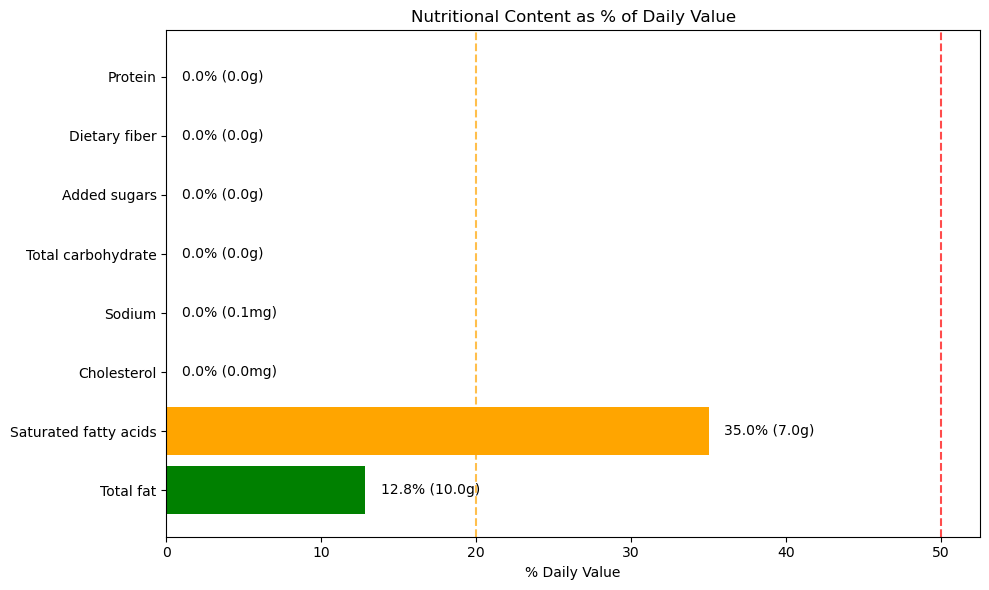


Product Analysis Options:
1. Allergen Check
2. Processing Score
3. Find Healthier Alternatives
4. Nutritional Analysis
5. Go Back to Main Menu



Select analysis type (1-5):  5



DIETARY COMPASS: PERSONALIZED FOOD CHOICE NAVIGATOR

Please select a tool:
1. Food Product Analyzer - Analyze food products in different ways
2. Know more about nutrition tag - Learn how to interpret food labels
3. Exit
--------------------------------------------------



Enter your choice (1-3):  3



Thank you for using Dietary Compass! Goodbye!


In [50]:
# Main function to run the Dietary Compass application
def main():
    ensure_menu_navigation()
if __name__ == "__main__":
    main()

### Demo 3--Know more about nutrition tag

In [52]:
# Main function to run the Dietary Compass application
def main():
    ensure_menu_navigation()
if __name__ == "__main__":
    main()


DIETARY COMPASS: PERSONALIZED FOOD CHOICE NAVIGATOR

Please select a tool:
1. Food Product Analyzer - Analyze food products in different ways
2. Know more about nutrition tag - Learn how to interpret food labels
3. Exit
--------------------------------------------------



Enter your choice (1-3):  2



Nutrition Facts Label Information Sections:
1. Serving Information
2. Calories
3. Nutrients
4. The Percent Daily Value (%DV)
5. Return to Main Menu



Select a section to learn more (1-5):  1



1. Serving Information
--------------------------------------------------
When looking at the Nutrition Facts label, first take a look at the number of servings in the
package (servings per container) and the serving size. Serving sizes are standardized to make it
easier to compare similar foods; they are provided in familiar units, such as cups or pieces,
followed by the metric amount, e.g., the number of grams (g). The serving size reflects the amount
that people typically eat or drink. **It is not a recommendation of how much you should eat or
drink**.

It’s important to realize that all the nutrient amounts shown on the label, including the number of
calories, refer to the size of the serving. **Pay attention to the serving size, especially how many
servings there are in the food package. For example, you might ask yourself if you are consuming ½
serving, 1 serving, or more**. In the sample label, one serving of lasagna equals 1 cup. If you ate
two cups, you would be consuming two


Select a section to learn more (1-5):  2



2. Calories
--------------------------------------------------
Calories provide a measure of how much energy you get from a serving of this food. In the example,
there are **280 calories** in one serving of lasagna. What if you ate the entire package? Then, you
would consume 4 servings, or **1,120 calories**.

To achieve or maintain a healthy body weight, balance the number of calories you eat and drink with
the number of calories your body uses. 2,000 calories a day is used as a general guide for nutrition
advice. Your calorie needs may be higher or lower and vary depending on your age, sex, height,
weight, and physical activity level. Learn your estimated calorie needs at
[https://www.myplate.gov/myplate-plan](https://www.myplate.gov/myplate-plan).


Remember: The number of servings you consume determines the number of calories you actually eat. Eating too many calories per day is linked to overweight and obesity.
----------------------------------------


Nutrition Facts Label Info


Select a section to learn more (1-5):  3



3. Nutrients
--------------------------------------------------
Nutrients to get less of: Saturated Fat, Sodium, and Added Sugars. Saturated fat, sodium, and added
sugars are nutrients listed on the label that may be associated with adverse health effects – and
Americans generally consume too much of them. They are identified as **nutrients to get less of**.
Eating too much saturated fat and sodium, for example, is associated with an increased risk of
developing some health conditions, like cardiovascular disease and high blood pressure. Consuming
too much added sugars can make it hard to meet important nutrient needs while staying within calorie
limits.


What are Added Sugars and How are they Different from Total Sugars?
----------------------------------------


Total Sugars
----------------------------------------
on the Nutrition Facts label includes sugars naturally present in many nutritious foods and
beverages, such as sugar in milk and fruit as well as any added sugars that m


Select a section to learn more (1-5):  4



4. The Percent Daily Value (%DV)
--------------------------------------------------
The % Daily Value (%DV) is the percentage of the Daily Value for each nutrient in a serving of the
food. The Daily Values are reference amounts (expressed in grams, milligrams, or micrograms) of
nutrients to consume or not to exceed each day.

The %DV shows how much a nutrient in a serving of a food contributes to a total daily diet.

The %DV helps you determine if a serving of food is high or low in a nutrient.

Do you need to know how to calculate percentages to use the %DV? No, because the label (the %DV)
does the math for you! It helps you interpret the nutrient numbers (grams, milligrams, or
micrograms) by putting them all on the same scale for the day (0-100%DV). The %DV column doesn't add
up vertically to 100%. Instead, the %DV is the **percentage of the Daily Value** for each nutrient
in a serving of the food. It can tell you if a serving of food is high or low in a nutrient and
whether a servi


Select a section to learn more (1-5):  5



DIETARY COMPASS: PERSONALIZED FOOD CHOICE NAVIGATOR

Please select a tool:
1. Food Product Analyzer - Analyze food products in different ways
2. Know more about nutrition tag - Learn how to interpret food labels
3. Exit
--------------------------------------------------



Enter your choice (1-3):  3



Thank you for using Dietary Compass! Goodbye!
